In [16]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.manifold import TSNE
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.metrics import r2_score

In [3]:
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))

users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|',
                 names=['user_id','age','gender','occupation','zip_code'])
users = users.drop(['zip_code'],axis=1)


data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','movie_id','rating','tstamp']).sample(frac=1)
data['date'] = pd.to_datetime(data['tstamp'],unit='s')
data = data.drop(['tstamp'],axis=1)

movies = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie_id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')

movies['year'] = movies['release date'].apply(get_year)
movies = movies.drop(['release date','video release date','IMDb URL'],axis=1)

movies = movies.set_index('movie_id')
users = users.set_index('user_id')
num_users = len(pd.unique(data['user_id']))
num_movie = len(pd.unique(data['movie_id']))
data_joined = data.join(movies,on='movie_id',how='inner').join(users,on='user_id',how='inner')
print(data_joined.head())
print(data_joined.dtypes)

       user_id  movie_id  rating                date  \
93354      934       131       4 1998-03-29 17:16:18   
85266      934       492       4 1998-03-29 17:21:27   
74797      934       174       5 1998-03-29 17:11:51   
90582      934       732       5 1998-03-29 17:54:49   
86884      934       154       3 1998-03-29 17:10:01   

                               movie title  unknown  Action  Adventure  \
93354        Breakfast at Tiffany's (1961)        0       0          0   
85266                  East of Eden (1955)        0       0          0   
74797       Raiders of the Lost Ark (1981)        0       1          1   
90582                          Dave (1993)        0       0          0   
86884  Monty Python's Life of Brian (1979)        0       0          0   

       Animation  Children  ...  Mystery  Romance  Sci-Fi  Thriller  War  \
93354          0         0  ...        0        1       0         0    0   
85266          0         0  ...        0        0       0         

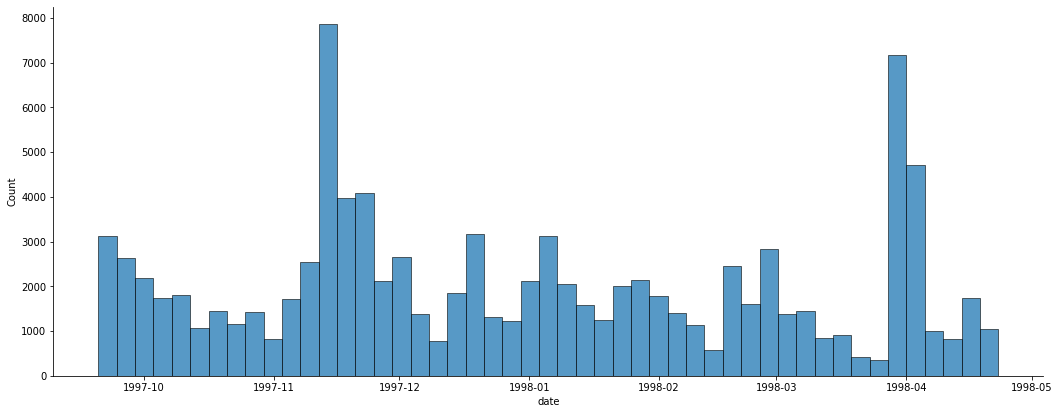

In [4]:
g = sns.displot(data_joined['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [5]:
#Date based split and Shuffle them. I thought it was already shuffled when I loaded it from CSV.
#But its not. So shuffle is important here
cutoff_date = '1998-03-01'
df_train = data_joined[data_joined['date'] < cutoff_date].sample(frac=1)
df_test = data_joined[data_joined['date'] >= cutoff_date].sample(frac=1)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

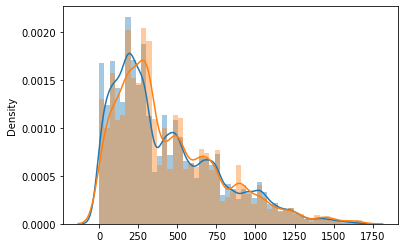

In [18]:
X_train = df_train[['user_id','movie_id']].to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test[['user_id','movie_id']].to_numpy() - 1
y_test = df_test['rating'].to_numpy()

sns.distplot(X_train[:,1])
sns.distplot(X_test[:,1])

In [7]:
print(len(np.unique(X_train[:,0])), len(np.unique(X_test[:,0])))
print(len(pd.unique(data['user_id'])))
print(len(np.unique(X_train[:,1])), len(np.unique(X_test[:,1])))
print(len(pd.unique(data['movie_id'])))

736 327
943
1608 1467
1682


In [19]:

def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
#                                        embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
#                                        embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")

model = collaborative_model(num_users,num_movie,64)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

Epoch 1/40
2194/2194 [==============================] - 7s 3ms/step - loss: 7.2478 - mse: 7.2466 - val_loss: 1.3646 - val_mse: 1.3648
Epoch 2/40
2194/2194 [==============================] - 7s 3ms/step - loss: 1.0452 - mse: 1.0451 - val_loss: 0.9836 - val_mse: 0.9834
Epoch 3/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.8846 - mse: 0.8845 - val_loss: 0.9401 - val_mse: 0.9400
Epoch 4/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.8083 - mse: 0.8082 - val_loss: 0.9229 - val_mse: 0.9226
Epoch 5/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.7399 - mse: 0.7399 - val_loss: 0.8983 - val_mse: 0.8981
Epoch 6/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.6731 - mse: 0.6732 - val_loss: 0.8885 - val_mse: 0.8883
Epoch 7/40
2194/2194 [==============================] - 7s 3ms/step - loss: 0.6074 - mse: 0.6074 - val_loss: 0.8957 - val_mse: 0.8954
Epoch 8/40
2194/2194 [==============================] - 6s 3ms

In [20]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set
unseen_indices = ~(np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id']))
X_test_unseen = X_test[unseen_indices]
y_test_unseen = y_test[unseen_indices]
print(X_test_unseen.shape,y_test_unseen.shape,X_test.shape)
y_pred = model(X_test_unseen)
tf.keras.metrics.mean_squared_error(y_test_unseen, y_pred)
r2_score(y_test_unseen, y_pred)

(18300, 2) (18300,) (22015, 2)


-10.06725666251857

In [23]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices =    np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id'])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)
r2_score(y_test_seen, y_pred)

(3715, 2) (3715,) (22015, 2)


0.20071266530730647

In [10]:
#TSNE for visualization
tsne = TSNE()
# users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies_embeddings = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies_embeddings)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



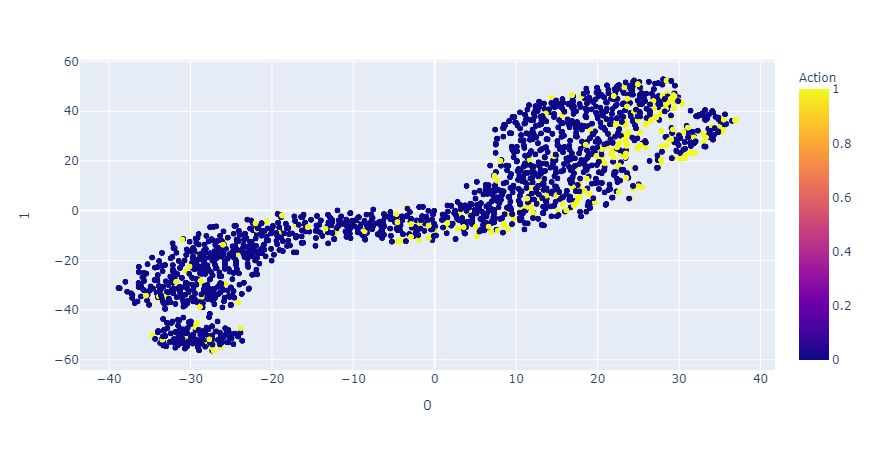

In [11]:
new_df[2] = movies['movie title'].to_numpy()
new_df.set_index(np.array(new_df.index)+1, inplace = True)
# new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)
new_df = pd.concat([new_df,movies[['unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western']]],axis=1)
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='Action')
fig.show()

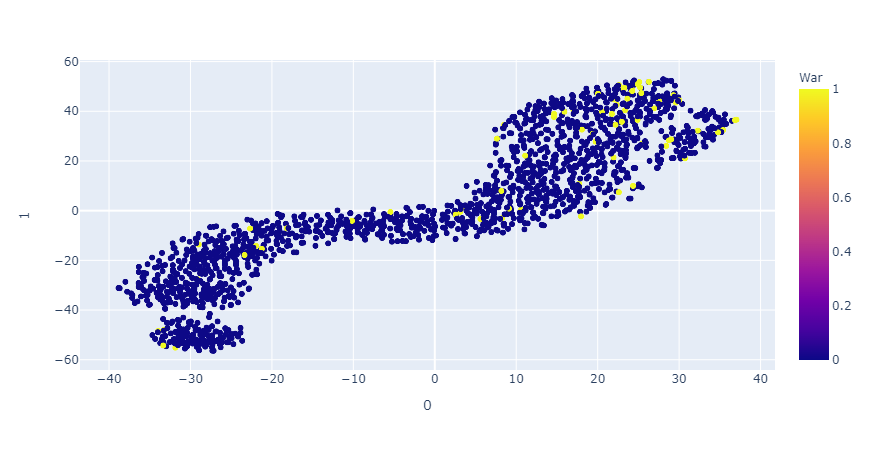

In [12]:
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='War')
fig.show()

In [8]:
#train
ohe = OHE(handle_unknown='ignore',sparse=False)
X_train = np.concatenate([df_train.drop(['date','movie_id',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_train[['gender','occupation']])],axis=1)

#test
X_test = np.concatenate([df_test.drop(['date','movie_id',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_test[['gender','occupation']])],axis=1)
print(X_train.shape)

(77985, 44)


In [30]:
#Network does not seem to converge. Either too much randomness in the data or the network is not stong
#enough. Its as good at learning embeddings as initializing them randomly.
def neural_embeddings_collaborative_model(data_dimension, user_data_start_index,emb_dim,drop_out=0.2):
    x_data = tf.keras.Input((data_dimension))
    x_movie_in = x_data[:,:user_data_start_index]
    x_user_in = x_data[:,user_data_start_index:]
    drop_out_layer = tf.keras.layers.Dropout(drop_out)
    x_user = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user_in))
    x_user = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user))
    x_user = tf.keras.layers.Dense(emb_dim,activation='relu')(x_user)
    x_movie = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie_in))
    x_movie = drop_out_layer(tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie))
    x_movie = tf.keras.layers.Dense(emb_dim,activation='relu')(x_movie)
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x_data, outputs=out, name="neural_embeddings_collaborative_model")


model = neural_embeddings_collaborative_model(X_train.shape[1],20,64)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=60,
    restore_best_weights=True
)])    

Epoch 1/40
2194/2194 [==============================] - 11s 5ms/step - loss: 23471.4004 - mse: 23464.0508 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 2/40
2194/2194 [==============================] - 10s 5ms/step - loss: 25.5958 - mse: 25.5923 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 3/40
2194/2194 [==============================] - 10s 4ms/step - loss: 14.1332 - mse: 14.1336 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 4/40
2194/2194 [==============================] - 9s 4ms/step - loss: 13.7711 - mse: 13.7722 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 5/40
2194/2194 [==============================] - 11s 5ms/step - loss: 14.7815 - mse: 14.7820 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 6/40
2194/2194 [==============================] - 10s 4ms/step - loss: 13.6955 - mse: 13.6961 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 7/40
2194/2194 [==============================] - 10s 4ms/step - loss: 13.6756 - mse: 13.6754 - val_loss: 13.6494 - val_mse: 13.6479
Epoch 8/40
2194/2194 [

In [34]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set 

unseen_indices = ~(np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id']))
X_test_unseen = X_test[unseen_indices]
y_test_unseen = y_test[unseen_indices]
print(X_test_unseen.shape,y_test_unseen.shape,X_test.shape)
y_pred = model(X_test_unseen)
tf.keras.metrics.mean_squared_error(y_test_unseen, y_pred)

(18300, 44) (18300,) (22015, 44)


<tf.Tensor: shape=(), dtype=float32, numpy=13.979071>

In [35]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(df_test['movie_id'],df_train['movie_id']) & np.isin(df_test['user_id'],df_train['user_id'])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)

(3715, 44) (3715,) (22015, 44)


<tf.Tensor: shape=(), dtype=float32, numpy=13.709825>

In [81]:
# simple model which simply spits out average rating for the movie. Assumes all users are average. Performs
#better than the neural net above
y_pred = []
avg_rating = df_train.groupby('movie_id').mean()
for movie_id in df_test['movie_id']:
    rating = avg_rating[avg_rating.index == movie_id]['rating'].to_numpy()
    if len(rating):
        y_pred.append(rating[0])
    else:
        y_pred.append(3)
        
r2_score(y_test,y_pred)

0.14659412692453677